(transformation_product_prediction)=

# Transformation Product Prediction (TPP)

In this tutorial, an algorithm for Transformation Product Prediction, will be explained. This is based on the repository [TP_predict](https://c4science.ch/source/TP_predict/browse/master/) and the paper [Trostel, L. et. al.](https://pubs.rsc.org/en/content/articlelanding/2023/em/d3em00161j). Their code showcases how enviPath can be used to generate a suspect list of transformation products for an environmental pathway. 

The goal that this tutorial aims to assess is: given a pathway as shown below, which is the node of the pathway that should be first explored. One can assess this problem by answering: what is the conditional probability of reaching the child nodes D, E and F?

![pathway1.png](../assets/pathway_example.png "")

We can achieve that by considering the probability of reaching the given node as the probability of the reaction multiplied by the probability of reaching the parent node (which again can be computed in the same way) and assigning as the probability of the root node (the compound that we will input) as 1. We will label the result of this probability multiplication as `node_probability`. In this way, the probability of getting D can be computed as follows:

$$
P(D) = P(D\leftarrow B)\cdot P(B) = \\ = P(D\leftarrow B)\cdot P(B\leftarrow A) \cdot P(A) =\\
     = 0.9 \cdot 0.9 \cdot 1 = 0.81
$$

In this tutorial, as it will be seen, when a node that it is already on the queue of compounds to explore is found through another path, the maximum of the computed probabilities will be assigned to the given node. In this way, one can compute the associated node probabilities (as seen on the figure below) and determine that the next node to be explored is D.

![pathway2.png](../assets/pathway_combined_probs.png "")

Each node that has not yet been explored will remain on a priority queue, where compounds with higher associated `node_probability` will be higher on the queue. In each iteration of the algorithm, the node with highest node probability (i.e. the one on the top of the queue) will be explored.

Once the theory is clear, let's dig into the code!

In [1]:
from enviPath_python.enviPath import *
from enviPath_python.objects import *

import pandas as pd
import getpass

First of all, one needs to generate a set of global variables to be used throughout the script. Please do note, that one can use any other model available on enviPath by providing a valid `EP_MODEL_ID`. If this model can only be accessed for specifics users, please uncomment the lines after `eP = enviPath(INSTANCE_HOST)`. The `compound_input` parameter contains the SMILES and description of the compound whose transformation products should be predicted. On the aforementioned repository, they generalize this to be a list of compounds, allowing in this way to perform a batch-processing exploration. The value `MAX_TP` encodes the maximum amount of transformation products that want to be searched. `PROBABILITY_THRESHOLD` indicates which is the minimum cut-off for a conditional probability to be considered as "unlikely" transformation product.

In [2]:
INSTANCE_HOST = 'https://envipath.org'
EP_MODEL_ID = 'https://envipath.org/package/32de3cf4-e3e6-4168-956e-32fa5ddb0ce1/relative-reasoning/23e1b2ec-dcc0-4389-9b65-afd52bd72e27'

# data of parent compound
compound_input = {"smiles": "CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=CC5=C(C(=C4)F)N=C(N5C(C)C)C)F", "name": "Abe"}

# Maximum number of TPs to predict
MAX_TP = 50

# Lower probability threshold
PROBABILITY_THRESHOLD = 0 # any value equal to or lower than the threshold will be excluded

eP = enviPath(INSTANCE_HOST)
# USERNAME = input("Please, provide your username: ")
# password = getpass.getpass()
# eP.login(USERNAME, password)

rr = RelativeReasoning(eP.requester, id=EP_MODEL_ID)

Next we define two functions to update entries on queues, that will be used afterwards on the body of the TP prediction algorithm.
* `update_queue`: it takes each SMILES from the list of transformation products and:
    * if already present on the queue or list of already predicted SMILES, it will update the data on those lists
    * else, it will add the SMILES to the queue of transformation products to be predicted
    
    Eventually, it sorts the queue by descending order of probability of the transformation product
* `update_compound_entry`: this function is used on the first bullet point of the previous explained function. If the node probability of obtaining the given SMILES is higher now than on the validated list of transformation products or on the current queue, it will update the information to add the current one.

In [3]:
def update_queue(queue, validated_TPs, TPs, parent_data):
    for smiles in TPs:
        data = TPs[smiles]
        # If the probability is 0 , we don't consider the TP further
        this_probability = data['probability']
        if this_probability <= PROBABILITY_THRESHOLD:
            continue
        data['node_probability'] = parent_data['node_probability'] * data['probability']
        data['generation'] = parent_data['generation'] + 1
        data['parent_smiles'] = [parent_data['smiles']]
        # first, check if compound already in validated. if yes, update
        if smiles in validated_TPs.keys():
            validated_TPs[smiles] = update_compound_entry(validated_TPs[smiles], data)
        # next, check if compound is already in queue. if yes, update
        elif smiles in queue:
            queue[smiles] = update_compound_entry(queue[smiles], data)
        # else, add new item to queue
        else:
            queue[smiles] = data

    # order dict by node probability
    queue = dict(sorted(queue.items(), key=lambda item: item[1]['node_probability'], reverse=True))

    return queue, validated_TPs

def update_compound_entry(reference_data, new_data):
    if reference_data['node_probability'] < new_data['node_probability']:
        reference_data['node_probability'] = new_data['node_probability']
        reference_data['rules'] += new_data["rules"]
        reference_data['rule_IDs'] += new_data["rule_IDs"]
        reference_data['generation'] = new_data['generation']
        reference_data['parent_smiles'] += new_data['parent_smiles']
    return reference_data

We begin the TP prediction algorithm by adding the root node to the queue. Then we enter on the loop that will last either until the maximum number of transformation products, `MAX_TP`, has been reached or until no more compounds are on the queue. On each round of this loop:

 1. The SMILES on top of the queue (the most probable) is retrieved
 2. The model is used to predict possible transformation products
 3. This information is ordered by probability
 4. Use each predicted transformation product to generate a dictionary of transformation products, `TP_dict`, where their relevant information is stored
 5. Use `TP_dict` on `update_queue` to update the queue, based on their probabilities
 6. Now the most probable SMILES has been explored, add its data to `validated_TPs` and go back to 1.

In [4]:
num_TP = -1 # counter starts at -1, because source compound is also in the TP list
validated_TPs = {}  # container for resulting predictions
queue = {compound_input['smiles']: {'probability': 1, 'node_probability': 1, 'smiles': compound_input['smiles'], 'generation': 0, 'parent_smiles': [''],
                    'rules': [''], 'rule_IDs': [''], 'name': compound_input['name']}}
while num_TP < MAX_TP:
    if len(queue) == 0:
        print('\nEmpty queue - The exploration of has converged at {} predicted TPs'.format(num_TP))
        break
    smiles = list(queue.keys())[0] # get top item in queue
    parent_data = queue.pop(smiles) # remove data from queued items

    # Perform a prediction based on the previously defined relative reasoning object
    prediction_data = rr.classify_smiles(smiles)
    
    # sort by probability
    prediction_data.sort(reverse=True, key=lambda x: x['probability'])

    TP_dict = {}
    for prediction in prediction_data:
        probability = float(prediction['probability'])
        for product_smiles in prediction['products']:
            if product_smiles not in TP_dict.keys():
                TP_dict[product_smiles] = {'rules' : [prediction['name']], 'rule_IDs': [prediction['id']], 'probability': probability, 'smiles': product_smiles}
            else:
                # check if there's a rule with better probability
                if probability > TP_dict[product_smiles]['probability']:
                    # update probability and rules associated to this probability
                    TP_dict[product_smiles]['probability'] = probability
                    TP_dict[product_smiles]['rules'] = [prediction['name']]
                    TP_dict[product_smiles]['rule_IDs'] = [prediction['id']]
    
    queue, validated_TPs = update_queue(queue, validated_TPs, TP_dict, parent_data)
    validated_TPs[smiles] = parent_data
    num_TP += 1
pd.DataFrame.from_dict(validated_TPs, orient='index').head()

,probability,node_probability,smiles,generation,parent_smiles,rules,rule_IDs,name
CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=CC5=C(C(=C4)F)N=C(N5C(C)C)C)F,1.0,1.0,CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=CC...,0,[],[],[],Abe
CCN1CCNCC1,0.4,0.4,CCN1CCNCC1,1,[CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=C...,[bt0063],[https://envipath.org/package/32de3cf4-e3e6-41...,NaN
CC(=O)C,0.4,0.4,CC(=O)C,1,[CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=C...,[bt0063],[https://envipath.org/package/32de3cf4-e3e6-41...,NaN
CC(C)N1C(=NC2=C1C=C(C=C2F)C3=NC(=NC=C3F)NC4=CC=C(C=N4)CN5CCNCC5)C,0.4,0.4,CC(C)N1C(=NC2=C1C=C(C=C2F)C3=NC(=NC=C3F)NC4=CC...,1,[CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=C...,[bt0063],[https://envipath.org/package/32de3cf4-e3e6-41...,NaN
CC(C)N1C(=NC2=C1C=C(C=C2F)C3=NC(=NC=C3F)NC4=CC=C(C=N4)C=O)C,0.4,0.4,CC(C)N1C(=NC2=C1C=C(C=C2F)C3=NC(=NC=C3F)NC4=CC...,1,[CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=C...,[bt0063],[https://envipath.org/package/32de3cf4-e3e6-41...,NaN


Finally, we can use the obtained dictionary to create a graph network using [Networkx](https://networkx.org/documentation/stable/index.html) and display it using [Plotly](https://plotly.com/python/). It is worth to mention that in order to generate the graph visualization, the following stackoverflow issues were used as an inspiration to generate a [tree based network graph](https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209) and to [display images as nodes](https://stackoverflow.com/questions/60254233/plot-sample-images-over-network-graph).

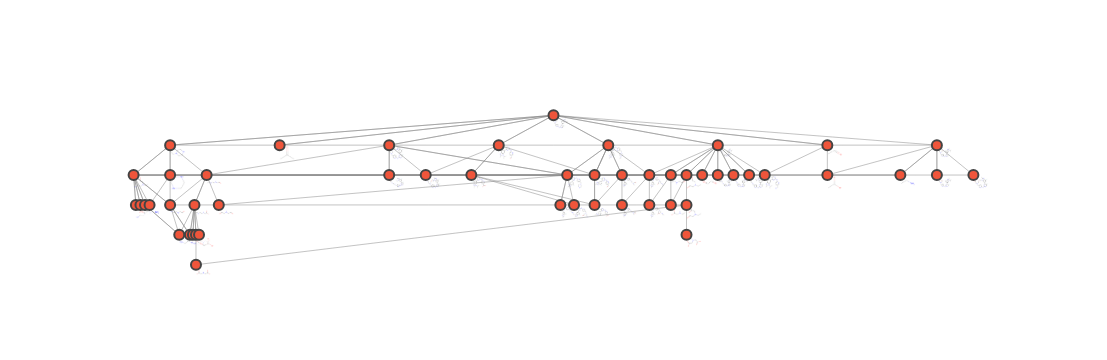

In [49]:
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw
import plotly.graph_objects as go

def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

G = nx.DiGraph()
edges = []
for node_i,data_i in validated_TPs.items():
    for node_f,data_f in validated_TPs.items():
        for i,parent_node in enumerate(validated_TPs[node_f]['parent_smiles']):
            if node_i == parent_node:
                edges.append((node_i, node_f, {"node_probability": data_f["node_probability"], "rule": data_f["rules"][i]}))
G.add_edges_from(edges)

pos = hierarchy_pos(G,compound_input["smiles"])

edge_positions = {"x": [], "y": []}
root_node = list(G.edges.keys())[0][0]
x, y = pos[root_node]

edge_positions = {"x": [], "y": []}
node_positions = {"smiles": [root_node], "x": [x], "y": [y]}
text = [f'<b>SMILES: {root_node}</b><br><b>Probability</b>: {validated_TPs[root_node]["node_probability"]}']
for edge in G.edges.data():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_positions["x"].extend([x0, x1])
    edge_positions["y"].extend([y0, y1])
    if edge[1] not in node_positions["smiles"]:
        node_positions["smiles"].append(edge[1])
        node_positions["x"].append(x1)
        node_positions["y"].append(y1)
        text.append(f'<b>SMILES: {edge[1]}</b><br><b>Probability</b>: {edge[2]["node_probability"]}<br><b>Rules</b>: {edge[2]["rule"]}')

edge_trace = go.Scatter(
    x=edge_positions["x"], y=edge_positions["y"],
    line=dict(width=0.5, color='#888'),
    mode='lines',
    hoverinfo='text')


node_trace = go.Scatter(
    x=node_positions["x"], y=node_positions["y"],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        size=10,
        line_width=2),
    text=text)

axis=dict(showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(showlegend=False, xaxis=go.layout.XAxis(axis), yaxis=go.layout.YAxis(axis),
                   plot_bgcolor='rgba(0, 0, 0, 0)', paper_bgcolor='rgba(0, 0, 0, 0)', )
fig = go.Figure(data=[edge_trace, node_trace], layout=layout)

xVals = fig['data'][1]['x']
yVals = fig['data'][1]['y']

for (i, smiles) in enumerate(node_positions["smiles"]):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    fig.add_layout_image(dict(
        source=img,
        x=xVals[i],
        y=yVals[i],
        xref="x",
        yref="y",
        sizex=0.1,
        sizey=0.1,
        opacity=0.7,
        layer="below"
    ))
fig.show()